12/29/2024

Learnings:
- Learned how to train a char-level using counts
- Learned to evaluate the model using Maximum Likelihood Estimation
- Learned the problem is the define a set of parameters that maximizes the likelihood of the dataset, which is equivalent to minimizing the negative log likelihood, this is done for semantics and convenience purposes
- Learned how to sample from this statistically learned model
- Matrix multiplication in the NN is the core input to parameter relationship. You are modeling a relationship of how the input as affected by the parameters. Then you will modify the parameters in a way to do maximum likelihood estimation.
- `xenc` shape: (batch_size, feature_size)
- `W` shape: (number of input features, number of neurons)
- when you do `xenc @ W`, the `output` is shape: (batch_size, activations or logits for each possible next character) -- or simply put, what is the firing rate for every neuron for every example
- With one-hot encoding as input, you effectively are selecting a row from `W`, where each element in the row is a given feature in all neurons (this is also called embedding lookup)
- Learned that a logit is the raw score that a NN outputs before it's converted into a probability. NN assigns scores (logits) to each possible outcome, these scores can be any real number (positive, negative, or zero). We then convert these scores into probabilities using the softmax function
- Learned that for the maximum likelihood, the likelihood of independent events ocurring together is the product of their individual probabilities. In practice though, multiplying many small probabilities can lead to numerical underflow so we use instead this transformation `log(a*b*c) = log(a) + log(b) + log(c)`. Addition is also computationally more stable than multiplication. And also, the log function is monotonic, so maximizing the log likelihood is equivalent to maximizing likelihood
- Learned that when we say an op is differentiable, we can: calculate how small changes in the inputs affect the output, propagate gradients backward through the operation during backprop

---

- Learned the forward pass is about taking inputs and running them through the network to generate predictions, compare against actuals, calculate how wrong the predictions were (loss). This tells us how good W was.
---
- When making a prediction, say you get the logits and softmax them into a probability distribution for every character. You still want to randomnly sample instead of argmax to allow for non-determinism and not predicting the same thing every time for a given input. This is related to temperature -- the lower the temp, the closer to argmax! Temperature is just a scaling factor on the logits before converting to probability distribution, ie. `scaled_logits = logits / temperature`, then `probs = softmax(scaled_logits, dim=1)` this means that temperature of zero approaches a one-hot vector (basically argmax), when temperature -> inf, distribution approaches uniform, when temp = 1, you get the original softmax probabilities!

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
words = [w.split(',')[0].lower() for w in words]

In [4]:
min_len, min_name = float('inf'), ''
max_len, max_name = 0, ''

for w in words:
    if len(w) < min_len:
        min_len = len(w)
        min_name = w
    if len(w) > max_len:
        max_len = len(w)
        max_name = w
print(min_len, min_name)
print(max_len, max_name)

2 an
15 muhammadibrahim


In [5]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1


In [6]:
sorted(b.items(), reverse=True, key=lambda x: x[1])

[(('n', '<E>'), 6804),
 (('a', '<E>'), 6681),
 (('a', 'n'), 5470),
 (('<S>', 'a'), 4437),
 (('e', '<E>'), 4020),
 (('a', 'r'), 3289),
 (('e', 'l'), 3269),
 (('r', 'i'), 3060),
 (('n', 'a'), 2993),
 (('<S>', 'k'), 2979),
 (('l', 'e'), 2933),
 (('e', 'n'), 2693),
 (('l', 'a'), 2633),
 (('m', 'a'), 2615),
 (('<S>', 'm'), 2565),
 (('a', 'l'), 2543),
 (('i', '<E>'), 2507),
 (('l', 'i'), 2495),
 (('i', 'a'), 2461),
 (('<S>', 'j'), 2441),
 (('o', 'n'), 2428),
 (('h', '<E>'), 2424),
 (('r', 'a'), 2376),
 (('a', 'h'), 2351),
 (('h', 'a'), 2260),
 (('y', 'a'), 2158),
 (('i', 'n'), 2146),
 (('<S>', 's'), 2073),
 (('a', 'y'), 2062),
 (('y', '<E>'), 2020),
 (('e', 'r'), 1971),
 (('n', 'n'), 1919),
 (('y', 'n'), 1836),
 (('k', 'a'), 1742),
 (('n', 'i'), 1736),
 (('r', 'e'), 1710),
 (('<S>', 'd'), 1700),
 (('i', 'e'), 1665),
 (('a', 'i'), 1661),
 (('<S>', 'r'), 1654),
 (('a', 'm'), 1640),
 (('l', 'y'), 1599),
 (('<S>', 'l'), 1577),
 (('<S>', 'c'), 1553),
 (('<S>', 'e'), 1536),
 (('j', 'a'), 1483),
 (

In [7]:
import torch

In [8]:
# Initializing matrix of N x N, where N is the number of characters -- 26 chars from the alphabet and '.' for the <S> or <E>.
N = torch.zeros((27, 27), dtype=torch.int32)

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [10]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

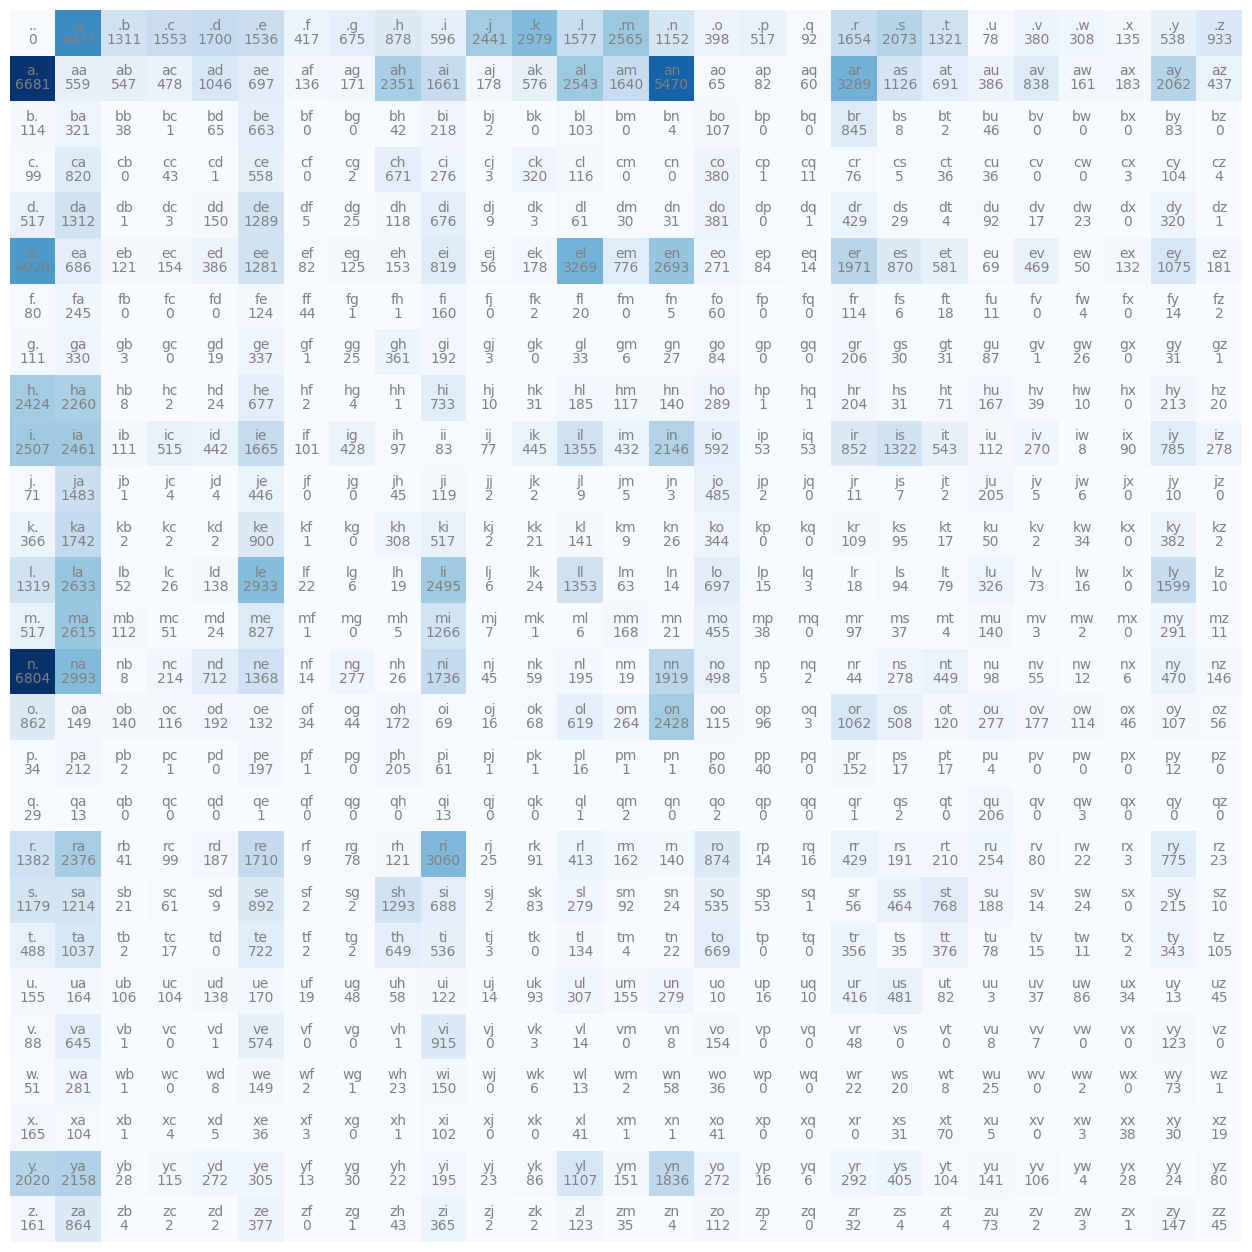

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

PabloNotes:
- Up until here, we've converted the names into bigrams and adding padding at the start or end of each word.
- You can do this cleanly by zipping elements: xip(x, x[1:]) which basically iterates elements like this: 0,1 then 1,2, then 2,3 and so on
- You can index the matrix by row or by column, so N[0] will bring the first row, or, N[:,0] for the first column

In [69]:
p = N[0].float()
p = p / p.sum()
p

# This illustrates the density across the first row, where each bigram is assigned relative mass

tensor([0.0000, 0.1376, 0.0407, 0.0482, 0.0527, 0.0476, 0.0129, 0.0209, 0.0272,
        0.0185, 0.0757, 0.0924, 0.0489, 0.0795, 0.0357, 0.0123, 0.0160, 0.0029,
        0.0513, 0.0643, 0.0410, 0.0024, 0.0118, 0.0096, 0.0042, 0.0167, 0.0289])

In [70]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'


p.sum()

In [75]:
P = (N+1).float() # Plus 1 is to prevent div-zero
P /= P.sum(1, keepdims=True) # this is normalizing to a probability distribution for each row

# The reason this makes sense on a row level
# Each result in the matrix represents the probability distribution of the next character given the current character, with smoothing for unseen combinations

"The end result is a matrix P where each row represents the probability distribution of the next character given the current character, with smoothing to handle rare or unseen combinations."

the matrix is 27 by 27 with each bigram combination possible.

consider the first row, it has 27 items.

which would be: 

.. , .a , .b, .c, .d, .e and so on.

here we are saying the current caracter is '.' and the next character would be a,b,c,d,e and so on.

so each item in the probability distribution is saying, given '.', the probability of 'a' is <whatever we normalized>

## Row 0 of matrix P represents:
## P[0] = [P(.|.), P(a|.), P(b|.), P(c|.), ..., P(z|.)]

For example:

- P[0,1] is P(a|.) - proability of 'a' given 'start of word'
- P[0,2] is P(b|.) - probability of 'b' given 'start of word'

In [90]:
max_prob = P[0].max()
max_idx = P[0].argmax() # ArgMax gets you the index with the highest value in the tensor
# The name "argmax" comes from mathematics, where "arg" stands for "argument" - meaning it returns the argument (input) that gives you the maximum value. In this case, the argument is the index position!
itos[max_idx.item()] # the letter most likely to start a name!!!!!!!!1

'a'

# Let's generate a name then!

In [95]:
P

tensor([[3.0988e-05, 1.3752e-01, 4.0656e-02, 4.8155e-02, 5.2710e-02, 4.7628e-02,
         1.2953e-02, 2.0948e-02, 2.7238e-02, 1.8500e-02, 7.5672e-02, 9.2343e-02,
         4.8898e-02, 7.9514e-02, 3.5729e-02, 1.2364e-02, 1.6052e-02, 2.8818e-03,
         5.1284e-02, 6.4268e-02, 4.0966e-02, 2.4480e-03, 1.1806e-02, 9.5752e-03,
         4.2143e-03, 1.6702e-02, 2.8942e-02],
        [1.9572e-01, 1.6403e-02, 1.6051e-02, 1.4030e-02, 3.0667e-02, 2.0445e-02,
         4.0128e-03, 5.0379e-03, 6.8891e-02, 4.8680e-02, 5.2430e-03, 1.6901e-02,
         7.4515e-02, 4.8065e-02, 1.6025e-01, 1.9332e-03, 2.4311e-03, 1.7867e-03,
         9.6365e-02, 3.3010e-02, 2.0269e-02, 1.1335e-02, 2.4575e-02, 4.7450e-03,
         5.3894e-03, 6.0426e-02, 1.2829e-02],
        [4.2767e-02, 1.1975e-01, 1.4504e-02, 7.4377e-04, 2.4544e-02, 2.4693e-01,
         3.7189e-04, 3.7189e-04, 1.5991e-02, 8.1443e-02, 1.1157e-03, 3.7189e-04,
         3.8676e-02, 3.7189e-04, 1.8594e-03, 4.0164e-02, 3.7189e-04, 3.7189e-04,
         3.1462e-

In [97]:
# In this example, we're doing the following
# 1. Start from the first row which is the probability of any char given start, ie. P(Any Char | .)
# 2. We sample a character from that row distribution
# - Remember, it's an index that it's being sampled with inherent probability
# 3. We append the sampled character, cur_char
# 4. Now we move the row to find the next character given the latest sampled character P(Any Char | cur_char)
# 5. if the sampled char is . then we're done and we print the name out

g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix] 
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # randomnly sample from the first row
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


### This is the statistics way for a name-generating model.
### Now, before reframing into a neural net -- we need a way to determine what is the quality of the model. In other words, how good is it predicting?

In [106]:
for w in words[:3]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    print(f"{ch1} {ch2}: {prob:.4f}")
# So here basically we looking at the probabilities that our model assigns to every bigram
# And compare to the ground truth, the dataset itself
# Basically, what's the probability that our model assigns to each bigram that we see in the dataset?
# The most naive model would be one that predicts with equal likelihood any next character
# In that case, since we have 27 characters, then a naive model would predict: 1/27 = 3.7% for any given character
# This means that our model should predict better than the 3.7% otherwise it's not a better predictor than random

. e: 0.0476
e m: 0.0377
m m: 0.0251
m a: 0.3889
a .: 0.1957
. o: 0.0124
o l: 0.0774
l i: 0.1775
i v: 0.0152
v i: 0.3500
i a: 0.1379
a .: 0.1957
. a: 0.1375
a v: 0.0246
v a: 0.2468
a .: 0.1957


In [121]:
# We want to summarize into a single number
# So we want the probability of the entire dataset as given by the model
# For convenience, we want the following;
log_likelihood = 0.0

for w in words[:3]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    print(f"{ch1} {ch2}: {prob:.4f}, {logprob:.4f}")

print(log_likelihood)

# Remember that log function:
# As the number is closer to 1 you get zero
# As the number is closer to 0 you get - infinity

# Also remember:
# log(a*b*c) = log(a) + log(b) + log(c)
# So we can just accumulate them by addition

# Note:
# The highest we could get here is if all bigrams were predicted with 100% probability
# Because log(1) = 0, then this would be the max case.

. e: 0.0476, -3.0443
e m: 0.0377, -3.2773
m m: 0.0251, -3.6838
m a: 0.3889, -0.9443
a .: 0.1957, -1.6311
. o: 0.0124, -4.3930
o l: 0.0774, -2.5591
l i: 0.1775, -1.7286
i v: 0.0152, -4.1876
v i: 0.3500, -1.0498
i a: 0.1379, -1.9810
a .: 0.1957, -1.6311
. a: 0.1375, -1.9840
a v: 0.0246, -3.7060
v a: 0.2468, -1.3990
a .: 0.1957, -1.6311
tensor(-38.8312)


In [126]:
# Finally, we want the semantics such that we can use a loss function and minimize it
# The lowest it can get is zero (better)
# The higher, the worse it is
# And finally, we want normalize it by the count to get the average negative log likelihood

neg_log_likelihood = 0.0
count = 0

for w in words[:3]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    neg_log_likelihood -= logprob
    count += 1 

print(f"Loss: {neg_log_likelihood/count:.4f}")


Loss: 2.4269


In [127]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# We reframe this for semantics and convenience to the following:

# Goal is to maximize the log likelihood (because log is monotonic, only goes up)
# Goal is to minimize the negative log likelihood (flipping the sign)
# Goal is to minimize the average negative log likelihood (averaging out)
# Log Property: log(a*b*c) = log(a) + log(b) + log(c)

In [138]:
# Now for the entire dataset

log_likelihood = 0.0
n = 0

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'Avg. negative loglikelihood: {nll/n}\nThis summarizes the model quality.')

log_likelihood=tensor(-563838.4375)
nll=tensor(563838.4375)
Avg. negative loglikelihood: 2.454684019088745
This summarizes the model quality.


## Now the neural network approach!

Neural Network
- Input: Single Character
- NN: Weights with params w
- Output: probability distribution of the next character in the sequence (what char follows)

We are able to evaluate any setting of the parameters because we can use the labels.
Basically you predict the output, and compare the distribution against the label.
This helps us evaluate and tune the weights

In [290]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [140]:
xs

tensor([ 0,  5, 13, 13,  1])

In [141]:
ys

tensor([ 5, 13, 13,  1,  0])

The dataset is created by:
- For every bigram, the first character is X
- The second character, which is the next-char we want to predict, comes in second place
- The indexes of the characters are positional, they don't have numerical meaning, so it doesn't make sense to put them into the neural net as is.
- Instead, we want to do one-hot encoding

In [142]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [144]:
xenc.shape

torch.Size([5, 27])

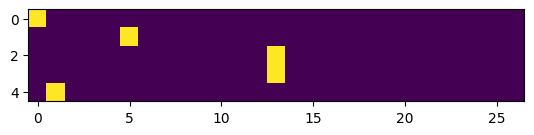

In [145]:
plt.imshow(xenc)

In [146]:
xenc.dtype

torch.float32

In [148]:
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [150]:
W

tensor([[-0.8263],
        [ 0.7461],
        [ 0.1244],
        [ 0.7836],
        [-0.1548],
        [ 1.0473],
        [ 1.0130],
        [ 1.7272],
        [ 0.2142],
        [-0.1889],
        [-0.6841],
        [ 0.5596],
        [ 2.3534],
        [ 1.0510],
        [ 0.1977],
        [ 0.3581],
        [-0.9108],
        [ 0.3270],
        [-1.0594],
        [ 0.2794],
        [-0.1120],
        [-1.1319],
        [-0.3362],
        [ 1.9905],
        [-0.6380],
        [-1.0316],
        [ 0.6814]])

In [156]:
W = torch.randn((27, 1)) # Create random weights with the normal distribution
xenc @ W # (5,27) @ (27,1)

# This multiplication yields that 5 activations of the neuron W, on the 5 inputs simoultaneously
# This means that we evaluate independently all the 5 interactions

# xenc shape: (5, 27)  - 5 examples, each with 27 features (one-hot encoded)
# W shape: (27, 1)     - 1 neuron with 27 weights

# xenc @ W -> (5,1) where each scalar is how much the neuron is activated for that input
# Note that every element of the output is independent of each other, they're just computed in the same operation but in the metal they're fully isolated

tensor([[-1.0201],
        [ 1.3264],
        [ 0.6415],
        [ 0.6415],
        [ 0.1423]])

In [162]:
xenc[3,:] @ W

tensor([0.6415])

Nice. We have here then:
- For every example, we do the dot product to get a scalar for every neuron 
- If you have 1 neuron, and each neuron has 27 weights (one per character), then you get (Nexamples, 1), eg. 5 examples gets you (5,1) output
- If you have 27 neuron, each with 27 weights, with 5 input examples, you get (5,27) output
- The output shape will be (number of examples, number of neurons)

In [163]:
W = torch.randn((27, 27)) # Create random weights with the normal distribution (27 neurons, 27 weights)

In [199]:
xenc[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [212]:
# W = [
#     [n1_p1, n2_p1, n3_p1, ..., n27_p1],    # weights for input feature 1
#     [n1_p2, n2_p2, n3_p2, ..., n27_p2],    # weights for input feature 2
#     [n1_p3, n2_p3, n3_p3, ..., n27_p3],    # weights for input feature 3
#     ...
#     [n1_p27, n2_p27, n3_p27, ..., n27_p27] # weights for input feature 27
# ]

W
# Think of W as:
# Each row represents one feature across all neurons
# If you get row 1, it will have the parameter 1 for all neurons
# So basically one column is all the parameters for a single neuron
# It's kind of like each neuron inspects the input and says, meeeeeeee!

tensor([[-7.2261e-01, -4.6123e-01,  4.5626e-01, -9.4232e-01,  2.9695e-01,
          1.2265e+00, -1.1295e+00,  4.5537e-01,  1.2566e+00, -1.3710e+00,
         -3.7965e-01,  6.6476e-01, -1.5307e+00,  1.2012e-01, -3.7325e-01,
          2.8367e-01,  4.0929e-01, -8.6958e-01, -1.0486e+00,  1.7540e+00,
          1.0716e+00,  2.4889e-01, -2.4292e-01,  3.7660e-01,  3.8618e-01,
          6.3744e-01,  1.3910e-01],
        [ 9.3976e-01,  5.5811e-01, -1.6291e+00,  1.2193e+00,  7.5211e-01,
          2.2045e+00,  1.9663e-01, -5.6363e-01, -5.1539e-01, -7.4833e-01,
          1.7306e+00, -1.0760e+00,  4.9489e-01,  1.2165e+00,  8.8347e-01,
         -9.0123e-01,  1.4081e-01, -3.8909e-01, -1.6576e-01,  2.2441e-01,
         -8.1364e-02,  2.3633e-01, -8.2054e-01, -7.5178e-02, -1.7794e+00,
          3.4808e-01,  1.5981e+00],
        [-2.5231e+00, -4.4186e-01, -5.4630e-01, -2.8209e-01,  8.1135e-01,
          1.9130e+00,  2.6148e+00,  5.1184e-01, -1.1117e+00,  1.1440e-01,
         -9.0704e-01,  1.2052e+00,  7.52

In [210]:
# 1st input example:
# [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
# Here's the output of the first example, which is essentially the first row of W
(xenc @ W)[0]

# The output here for one example is (27,1)
# This means, how strongly each neuron activates when seeing some char
# These 27 values will become logits/scores for predicting what comes after the given character, so given some char, how likely is each other char 

tensor([-0.7226, -0.4612,  0.4563, -0.9423,  0.2969,  1.2265, -1.1295,  0.4554,
         1.2566, -1.3710, -0.3797,  0.6648, -1.5307,  0.1201, -0.3733,  0.2837,
         0.4093, -0.8696, -1.0486,  1.7540,  1.0716,  0.2489, -0.2429,  0.3766,
         0.3862,  0.6374,  0.1391])

In [228]:
(xenc @ W)[3,13]

# This is telling you:
# For the input #3, what is the firing rate of the 13th neuron

tensor(0.0379)

In [237]:
W

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9644e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2844e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4040e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0731e-02,
          2.4968e+00,  2.4448e+00],
        [-6.7006e-01, -1.2199e+00,  3.0314e-01, -1.0725e+00,  7.2762e-01,
          5.1114e-02,  1.3095e+00, -8.0220e-01, -8.5042e-01, -1.8068e+00,
          1.2523e+00, -1.2256e+00,  1.2165e+00, -9.6478e-01, -2.3211e-01,
         -3.4762e-01,  3.3244e-01, -1.3263e+00,  1.1224e+00,  5.9641e-01,
          4.5846e-01,  5.4011e-02, -1.7400e+00,  1.1560e-01,  8.0319e-01,
          5.4108e-01, -1.1646e+00],
        [ 1.4756e-01, -1.0006e+00,  3.8012e-01,  4.7328e-01, -9.1027e-01,
         -7.8305e-01,  1.3506e-01, -2.1161e-01, -1.0406e+00, -1.5367e+00,
          9.3743e-01, -8.8303e-01,  1.74

In [239]:
W[:,0] # This is getting the first column of W 

tensor([ 1.5674, -0.6701,  0.1476,  1.2473, -1.5723,  0.4724,  1.2482, -1.2230,
         0.7061, -0.1607,  0.1611, -1.5437, -0.5913,  0.1936,  1.9217, -0.7786,
        -0.3459,  1.0904,  0.1876, -0.6285,  2.7930,  0.4570,  0.6540,  2.0021,
         0.2163,  0.7414,  1.0669])

In [242]:
W[:,13] # This is getting the 13th column

tensor([-4.3297e-01, -9.6478e-01,  2.1346e+00, -7.2759e-01, -1.3753e-01,
        -1.3132e-03, -3.1566e-01,  1.1199e+00, -4.7701e-01, -1.5065e+00,
         1.2108e+00, -4.0636e-01,  1.9110e-01,  3.7882e-02,  1.3431e+00,
         2.4311e-01, -1.5364e-01, -1.1583e+00,  1.1614e+00,  4.2016e-01,
         2.7359e-01,  3.6583e-01,  1.7128e+00,  1.3769e+00, -8.9778e-01,
        -9.5177e-01,  1.4723e-01])

In [243]:
(xenc[3] * W[:, 13])

tensor([-0.0000, -0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000,
        -0.0000, 0.0000, -0.0000, 0.0000, 0.0379, 0.0000, 0.0000, -0.0000, -0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, 0.0000])

In [244]:
(xenc[3] * W[:, 13]).sum()

tensor(0.0379)

In [232]:
# Should be equivalent to this:
(xenc[3] @ W)[13]

tensor(0.0379)

Now what we want as output is probability distribution:
- We will interpret the `xenc @ W` as logcounts
- To get the counts, we'll take logcounts and exponentiate the

The Exp function:
- takes the entire real numbers line, any number
- if you pass zero, it will be 1
- the more negative it is, it asymptotes towards zero with any negative number being below one
- the more positive it is, the closest to positive infinity

In [248]:
logits = xenc @ W # log-counts
counts = logits.exp() # equivalent N array we used before

In [249]:
counts

tensor([[ 4.7940,  0.7888,  0.9730,  0.3326,  1.3309,  0.9708,  0.2129,  1.8311,
          1.0824,  2.4710,  0.6242,  2.1964,  0.7200,  0.6486,  3.9469, 18.7908,
          4.7673,  0.1967,  1.9683,  0.4315,  2.6775,  0.8621,  0.2277,  1.5656,
          0.9317, 12.1434, 11.5281],
        [ 1.6038,  4.4060,  1.3737,  2.8830, 11.0032,  1.5972,  0.5187,  1.8527,
          0.5369,  1.6654,  3.8818,  1.2642,  0.6339,  0.9987,  0.5995,  1.7432,
          1.6073,  0.2499,  5.0680,  1.1876,  2.6871,  1.6596,  2.7728,  0.1486,
          0.6521,  0.1193,  2.6128],
        [ 1.2136,  2.8669,  1.8850,  1.2942,  2.6224,  0.7799,  1.0251,  0.9701,
          4.7691,  0.6386,  0.2910,  3.0710,  0.5098,  1.0386,  0.5719,  0.4373,
          2.2763,  0.4719,  2.5289,  0.2265,  0.8082,  0.3054,  0.5164,  0.7918,
          4.6866,  1.8232,  0.4921],
        [ 1.2136,  2.8669,  1.8850,  1.2942,  2.6224,  0.7799,  1.0251,  0.9701,
          4.7691,  0.6386,  0.2910,  3.0710,  0.5098,  1.0386,  0.5719,  0.4373

In [251]:
probs = counts / counts.sum(1, keepdims=True) # this is summing across the first dimension

In [252]:
probs[0]

tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])

In [253]:
probs[0].shape

torch.Size([27])

In [254]:
probs[0].sum()

tensor(1.)

In [255]:
# (5, 27) @ (27, 27) -> (5, 27)

In [256]:
# SUMMARY ------------------------------>>>>

In [257]:
xs

tensor([ 0,  5, 13, 13,  1])

In [258]:
ys

tensor([ 5, 13, 13,  1,  0])

In [289]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [261]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

From wikipedia:

The softmax function, also known as softargmax or normalized exponential function, converts a vector of K real numbers into a probability distribution of K possible outcomes. It is a generalization of the logistic function to multiple dimensions, and is used in multinomial logistic regression. The softmax function is often used as the last activation function of a neural network to normalize the output of a network to a probability distribution over predicted output classes.

This makes a lot of sense!

In [263]:
probs


tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

So now, every row in probs:
is the probability distribution for every possible next character

Summary:
- (`xenc` @ `W`): With one-hot encoding, we have the activation for every neuron, for every example. (5,27) where 5 is the batch_size and 27 the neuron count
- Now we convert the activation (logit) into a normalized probability distribution. This is done by exp every output and dividing by the sum of every row
- Now we have:
- input -> neural net -> probability for each character given input

In [266]:
probs.shape

torch.Size([5, 27])

In [271]:

nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('\n\n=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

# Again, here we want to the likelihood of the dataset so we'd multiply all actual probabilities
# A better approach is to get logs and use the property log(a*b*c) = log(a)+log(b)+log(c)
# for better semantics we use the negative, so -log likelihood
# And in practice, instead of the sum, we do the average so log(a) + log(b) + log(c) / 3

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.012286253273487091
log likelihood: -4.3992743492126465
negative log likelihood: 4.3992743492126465
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character:

In [272]:
# --------- !!! OPTIMIZATION !!! yay --------------

In [273]:
xs

tensor([ 0,  5, 13, 13,  1])

In [274]:
ys

tensor([ 5, 13, 13,  1,  0])

In [291]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [292]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [293]:
print(loss.item())

3.7693049907684326


In [294]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [295]:
W.data += -0.1 * W.grad

In [296]:
# forward pass with new weights
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [297]:
loss

tensor(3.7492, grad_fn=<NegBackward0>)

In [286]:
# --------- !!! OPTIMIZATION !!! yay, but this time actually --------------

In [298]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  229699


In [301]:
# gradient descent
for k in range(20):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

2.6776490211486816
2.6610796451568604
2.6466217041015625
2.633930206298828
2.6227316856384277
2.612802743911743
2.603957414627075
2.596041202545166
2.5889241695404053
2.582498073577881
2.576669692993164
2.571362257003784
2.566511392593384
2.562061309814453
2.557965040206909
2.5541837215423584
2.550682544708252
2.547434091567993
2.544412851333618
2.5415966510772705


In [302]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

cexza.
mogllurailezityha.
konimittain.
llayn.
ka.
